<a href="https://colab.research.google.com/github/shyamad/Facebook/blob/master/Copy_of_FB_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading graph
if not os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('/content/drive/My Drive/Facebook/data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [ ]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('/content/drive/My Drive/Facebook/data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/content/drive/My Drive/Facebook/data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('/content/drive/My Drive/Facebook/data/after_eda/missing_edges_final.p','rb'))

CPU times: user 3.96 s, sys: 773 ms, total: 4.73 s
Wall time: 5.77 s


In [ ]:
len(missing_edges)

9437519

In [ ]:
from sklearn.model_selection import train_test_split
# if (not os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/test_pos_after_eda.csv')) and (not os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/test_pos_after_eda.csv')):
#     #reading total data df
df_pos = pd.read_csv('/content/drive/My Drive/Facebook/data/train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
x_train_pos,x_test_pos,y_train_pos,y_test_pos=train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2,random_state=10)
x_train_neg,x_test_neg,y_train_neg, y_test_neg=train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2,random_state=10)

x_train=x_train_pos.append(x_train_neg,ignore_index=True)
y_train=np.concatenate((y_train_pos, y_train_neg))

x_test=x_test_pos.append(x_test_neg,ignore_index=True)
y_test=np.concatenate((y_test_pos,y_test_neg))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(15100030, 2)
(15100030,)
(3775008, 2)
(3775008,)


In [ ]:
if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_pos_after_eda.csv'):
  train_graph=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(train_graph))
else:
  print("please download the files from drive")    


Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [ ]:
if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/test_pos_after_eda.csv'):
  test_graph=nx.read_edgelist('/content/drive/My Drive/Facebook/data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
  print(nx.info(test_graph))
else:
  print("please download the files from drive")    



Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490


In [ ]:
x=pd.read_csv('/content/drive/My Drive/Facebook/data/after_eda/test_pos_after_eda.csv')
print(x.head())
y=list(train_graph.successors(848424))
print(y)
y_suc=list(train_graph.successors(784690))
print(y_suc)
y_pre1=list(train_graph.predecessors(848424))
print(y_pre1)
y_pre2=list(train_graph.predecessors(784690))
print(y_pre2)

    848424   784690
0  1248963   444518
1   264224   132395
2   549680   326829
3   875380  1394902
4  1315983   196578
[868707, 236489, 1744861, 621332, 1538385, 997389]
[468448, 1284157, 1453712, 996477, 848424, 1125837, 656142, 471573, 1540008]
[997389, 236489, 784690, 621332, 868707, 1538385]
[1453712, 40878, 621332, 1520509, 752347, 1284157, 1540008, 656142, 1766717, 264833, 323889, 312427, 671375, 703906]


In [ ]:
# Jaccard distance for followees
def jaccard_for_followees(a,b):
  try:
    if len(set(train_graph.successors(a))) ==0 | len(set(train_graph.successors(b)))==0:
      return 0
    else:
      JD= (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/(len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
      return JD
  except:
    return 0
  
print(jaccard_for_followees(848424,784690)) 


0.0


In [ ]:
#Jacard distance for followers
def jaccard_for_followers(a,b):
  try:
    if len(set(train_graph.predecessors(a)))==0 | len(set(train_graph.predecessors(b)))==0:
      return 0
    else:
      JD= (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/(len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
      return JD
  except:
    return 0 
 
print(jaccard_for_followers(848424,784690))   

0.05263157894736842


In [ ]:
print(x_train)
print(len(x_train))


          source_node  destination_node
0               17968            449506
1             1150315            598880
2             1752907           1600628
3              526734            935172
4              707426            117418
...               ...               ...
15100025      1313347            703014
15100026      1276564           1650084
15100027      1705624            128054
15100028       892815           1556973
15100029      1326707           1018633

[15100030 rows x 2 columns]
15100030


In [ ]:
import random
if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv'):
  filename='/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv'
  x_train=15100030
  desired_train=100000
  train_skip=sorted(random.sample(range(1,x_train+1),x_train - desired_train))


In [ ]:
import random
if os.path.isfile('/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv'):
  filename='/content/drive/My Drive/Facebook/data/after_eda/test_after_eda.csv'
  x_test=3775008
  desired_test=50000
  test_skip=sorted(random.sample(range(1,x_test+1),x_test - desired_test))


In [ ]:
df_train=pd.read_csv('/content/drive/My Drive/Facebook/data/after_eda/train_after_eda.csv',skiprows=train_skip, names=['source_node', 'destination_node'])
df_train.shape
df_train.head(5)
y_train_f=pd.read_csv('/content/drive/My Drive/Facebook/data/train_y.csv',skiprows=train_skip,names=['class'])

In [ ]:
y_train_f.shape

(100001, 1)

In [ ]:
df_test=pd.read_csv('/content/drive/My Drive/Facebook/data/after_eda/test_after_eda.csv',skiprows=test_skip,names=['source_node','destination_node'])
df_test.shape
y_test_f=pd.read_csv('/content/drive/My Drive/Facebook/data/test_y.csv',skiprows=test_skip,names=['test_class'])

In [ ]:
y_test_f.shape

(50001, 1)

In [ ]:
df_test.columns

Index(['source_node', 'destination_node'], dtype='object')

In [ ]:
df_train['J_followees']=df_train.apply(lambda x:jaccard_for_followees(x['source_node'],x['destination_node']),axis=1)
df_test['J_followees']=df_test.apply(lambda x:jaccard_for_followees(x['source_node'],x['destination_node']),axis=1)

                                                                                       

In [ ]:
df_train['J_followers']=df_train.apply(lambda x:jaccard_for_followers(x['source_node'],x['destination_node']),axis=1)
df_test['J_followers']=df_test.apply(lambda x:jaccard_for_followers(x['source_node'],x['destination_node']),axis=1)

In [ ]:
print(df_train.head(10))
print(df_train.shape)

   source_node  destination_node  J_followees  J_followers
0       273084           1505602     0.000000     0.000000
1      1462461           1600294     0.153846     0.090909
2      1785341           1843022     0.058824     0.000000
3       975298           1518413     0.055556     0.071429
4      1347865            386427     0.000000     0.000000
5       187975            139456     0.000000     0.000000
6       523209            645606     0.000000     0.014706
7      1153748            690012     0.000000     0.012500
8      1123732           1068536     0.200000     0.000000
9       323609           1662850     0.000000     0.071429
(100001, 4)


In [ ]:
# cosine samilarity for followees
def cosine_for_followees(a,b):
  try:
    if len(set(train_graph.successors(a)))==0 | len(set(train_graph.successors(b)))==0:
      return 0
    else:
      sim= (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))) / (math.sqrt(len(set(train_graph.successors(a))) * len(set(train_graph.successors(b)))))
      return sim
  except:
    return 0
  return sim

In [ ]:
# cosine similarity for followers
def cosine_for_followers(a,b):
  try:
    if len(set(train_graph.predecessors(a)))==0 | len(set(train_graph.predecessors(b)))==0:
      return 0
    else:
      sim= (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b))))) / (math.sqrt(len(set(train_graph.predecessors(a)))* len(set(train_graph.predecessors(b)))))
      return sim
  except:
    return 0
  return sim     


In [ ]:
df_train['cos_followees']=df_train.apply(lambda x:cosine_for_followees(x['source_node'],x['destination_node']),axis=1)
df_test['cos_followees']=df_test.apply(lambda x:cosine_for_followees(x['source_node'],x['destination_node']),axis=1)

In [ ]:
df_train['cos_followers']=df_train.apply(lambda x:cosine_for_followers(x['source_node'],x['destination_node']),axis=1)
df_test['cos_followers']=df_test.apply(lambda x:cosine_for_followers(x['source_node'],x['destination_node']),axis=1)

In [ ]:
pr=nx.pagerank(train_graph,alpha=0.85)

  

In [ ]:
pr_mean=float(sum(pr.values()))/len(pr)

In [ ]:
print(pr_mean)

5.615699699389075e-07


In [ ]:
pr_test=nx.pagerank(test_graph,alpha=0.85)
pr_mean_test=float(sum(pr_test.values()))/len(pr_test)

In [ ]:
df_test['Page_Rank_s']=df_test.source_node.apply(lambda x: pr_test.get(x,pr_mean_test))
df_test['Page_Rank_d']=df_test.destination_node.apply(lambda x: pr_test.get(x,pr_mean_test))

In [ ]:
# pagerank for train
df_train['Page_Rank_s']=df_train.source_node.apply(lambda x:pr.get(x,pr_mean))
df_train['Page_Rank_d']=df_train.destination_node.apply(lambda x:pr.get(x,pr_mean))

In [ ]:
def calculate_shortest_path_length(a,b):
    l=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            l= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            l= nx.shortest_path_length(train_graph,source=a,target=b)
        return l
    except:
        return -1
print(calculate_shortest_path_length(77697,1056459))


11


In [ ]:
df_train['shortest_path']=df_train.apply(lambda x:calculate_shortest_path_length(x['source_node'],x['destination_node']),axis=1)


In [ ]:
def compute_shortest_path_length(a,b):
  p=-1
  try:
    if test_graph.has_edge(a,b):
      test_graph.remove_edge(a,b)
      p=nx.shortest_path_length(test_graph, source=a, target=b)
      test_graph.add_edge(a,b)
    else:
      p=nx.shortest_path_length(test_graph,source=a,target=b)
    return p
  except:
    return -1



In [ ]:
df_test['shortest_path']=df_test.apply(lambda x:compute_shortest_path_length(x['source_node'],x['destination_node']),axis=1)


In [ ]:
# weekly connected edges from the train graph
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if calculate_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0


In [ ]:
belongs_to_same_wcc(861, 1659750)

0

In [ ]:
df_train['same_wcc']=df_train.apply( lambda x:belongs_to_same_wcc(x['source_node'],x['destination_node']),axis=1)

In [ ]:
# weekly connected components for the test graph
wcc=list(nx.weakly_connected_components(test_graph))
def belongs_to_same_wcc_test(a,b):
    index = []
    if test_graph.has_edge(b,a):
        return 1
    if test_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                test_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    test_graph.add_edge(a,b)
                    return 0
                else:
                    test_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0


In [ ]:
df_test['same_wcc']=df_test.apply(lambda x:belongs_to_same_wcc_test(x['source_node'],x['destination_node']),axis=1)

In [ ]:
# adar_index for train graph
def cal_adar_index(a,b):
  sum=0
  try:
    n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
    if len(n)!=0:
      for i in n:
        sum= sum+ (1/(np.log10(len(list(train_graph.predecessors(i))))))
      return sum
    else:
      return 0
  except:
    return 0
def cal_adar_index_test(a,b):
  sum=0
  try:
    n=list(set(test_graph.successors(a)).intersection(set(test_graph.successors(b))))
    if len(n)!=0:
      for i in n:
        sum= sum+ (1/(np.log10(len(list(test_graph.predecessors(i))))))
      return sum
    else:
      return 0
  except:
    return 0

In [ ]:
cal_adar_index(1,189226)

0

In [ ]:
df_train['adar_index']=df_train.apply(lambda x:cal_adar_index(x['source_node'],x['destination_node']),axis=1)

In [ ]:
df_test['adar_index']=df_test.apply(lambda x :cal_adar_index_test(x['source_node'],x['destination_node']),axis=1)


In [ ]:
def follow_back(a,b):
  if train_graph.has_edge(b,a):
    return 1
  else:
    return 0
def follow_back_test(a,b):
  if test_graph.has_edge(b,a):
    return 1
  else:
    return 0


In [ ]:
df_train['f_back']=df_train.apply(lambda x: follow_back(x['source_node'],x['destination_node']),axis=1)


In [ ]:
df_test['f_back']=df_test.apply(lambda x:follow_back_test(x['source_node'],x['destination_node']),axis=1)

In [ ]:
# katz centrality
katz_train = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
mean_katz_train = float(sum(katz_train.values())) / len(katz_train)

katz_test = nx.katz.katz_centrality(test_graph,alpha=0.005,beta=1)
mean_katz_test = float(sum(katz_test.values())) / len(katz_test)

In [ ]:
df_train['katz_s']=df_train.source_node.apply(lambda x:katz_train.get(x,mean_katz_train))
df_train['katz_d']=df_train.destination_node.apply(lambda x: katz_train.get(x,mean_katz_train))

In [ ]:
df_test['katz_s']=df_test.source_node.apply(lambda x:katz_test.get(x,mean_katz_test))
df_test['katz_d']=df_test.destination_node.apply(lambda x:katz_test.get(x,mean_katz_test))

In [ ]:
# HITS SCORE
# hits_train = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
# hits_test = nx.hits(test_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
hits = pickle.load(open('/content/drive/My Drive/Facebook/data/fea_sample/hits.p','rb'))

In [ ]:
#using HITS for train 
df_train['hubs_s']=df_train.source_node.apply(lambda x:hits[0].get(x,0))
df_train['hubs_d']=df_train.destination_node.apply(lambda x:hits[0].get(x,0))

df_train['authorities_s']=df_train.source_node.apply(lambda x:hits[1].get(x,0))
df_train['authorities_d']=df_train.destination_node.apply(lambda x:hits[1].get(x,0))


In [ ]:
# using HITS for test
df_test['hubs_s']=df_test.source_node.apply(lambda x:hits[0].get(x,0))
df_test['hubs_d']=df_test.destination_node.apply(lambda x:hits[0].get(x,0))

df_test['authorities_s']=df_test.source_node.apply(lambda x:hits[1].get(x,0))
df_test['authorities_d']=df_test.destination_node.apply(lambda x:hits[1].get(x,0))



In [ ]:
#weight for source and destination for train and test
from tqdm import tqdm
weight_in={}
weight_out={}
for i in tqdm(train_graph.nodes()):
  s1=set(train_graph.predecessors(i))
  w1=1/(np.sqrt(1+len(s1)))
  weight_in[i]=w1

  s2=set(train_graph.successors(i))
  w2=1/(np.sqrt(1+len(s2)))
  weight_out[i]=w2

mean_weight_in=np.mean(list(weight_in.values()))
mean_weight_out=np.mean(list(weight_out.values()))


weight_in_test={}
weight_out_test={}
for i in tqdm(test_graph.nodes()):
  s1_test=set(test_graph.predecessors(i))
  w1_test=1/(np.sqrt(1+len(s1_test)))
  weight_in_test[i]=w1_test

  s2_test=set(test_graph.successors(i))
  w2_test=1/(np.sqrt(1+len(s2_test)))
  weight_out_test[i]=w2_test

mean_weight_in_test=np.mean(list(weight_in_test.values()))
mean_weight_out_test=np.mean(list(weight_out_test.values()))




100%|██████████| 1144623/1144623 [00:09<00:00, 125246.97it/s]


In [ ]:
df_train['weight_in']=df_train.destination_node.apply(lambda x:weight_in.get(x,mean_weight_in))
df_train['weight_out']=df_train.source_node.apply(lambda x:weight_out.get(x,mean_weight_out))

df_train['weight_f1']=df_train.weight_in + df_train.weight_out
df_train['weight_f2']= df_train.weight_in * df_train.weight_out
df_train['weight_f3']= 2*df_train.weight_in + 1*df_train.weight_out
df_train['weight_f4']= 1*df_train.weight_in + 2*df_train.weight_out

In [ ]:
df_test['weight_in']=df_test.destination_node.apply(lambda x: weight_in_test.get(x,mean_weight_in_test))
df_test['weight_out']=df_test.source_node.apply(lambda x: weight_in_test.get(x,mean_weight_in_test))

df_test['weight_f1']= df_test.weight_in +  df_test.weight_out
df_test['weight_f2']= df_test.weight_in *  df_test.weight_out
df_test['weight_f3']= 2*df_test.weight_in + 1*df_test.weight_out
df_test['weight_f4']= 1*df_test.weight_in + 2*df_test.weight_out


In [ ]:
#number of followers of source and destination of train
def calculate_followees_followers_count(dataframe):
  n_followers_source=[]
  n_followee_source=[]
  n_followers_destination=[]
  n_followee_destination=[]
  for i, j in dataframe.iterrows():
    try:
      a1=set(train_graph.predecessors(j['source_node']))
      a2=set(train_graph.successors(j['source_node']))
    except:
      a1=set()
      a2=set()
    try:
      b1=set(train_graph.predecessors(j['destination_node']))
      b2=set(train_graph.successors(j['destination_node']))
    except:
      b1=set()
      b2=set()
    n_followers_source.append(len(a1))
    n_followee_source.append(len(a2))
    n_followers_destination.append(len(b1))
    n_followee_destination.append(len(b2))
  return n_followee_source,n_followers_source,n_followee_destination,n_followers_destination

In [ ]:
df_train['n_followers_source'],df_train['n_followee_source'],df_train['n_followers_destination'],df_train['n_followee_destination']=calculate_followees_followers_count(df_train)

In [ ]:
#number of followers of source and destination of test
def calculate_followees_followers_count_test(dataframe):
  n_followers_source=[]
  n_followee_source=[]
  n_followers_destination=[]
  n_followee_destination=[]
  for i, j in dataframe.iterrows():
    try:
      a1=set(test_graph.predecessors(j['source_node']))
      a2=set(test_graph.successors(j['source_node']))
    except:
      a1=set()
      a2=set()
    try:
      b1=set(test_graph.predecessors(j['destination_node']))
      b2=set(test_graph.successors(j['destination_node']))
    except:
      b1=set()
      b2=set()
    n_followers_source.append(len(a1))
    n_followee_source.append(len(a2))
    n_followers_destination.append(len(b1))
    n_followee_destination.append(len(b2))
  return n_followee_source,n_followers_source,n_followee_destination,n_followers_destination

In [ ]:
df_test['n_followers_source'],df_test['n_followee_source'],df_test['n_followers_destination'],df_test['n_followee_destination']=calculate_followees_followers_count(df_test)

In [ ]:
x=np.array(df_train['n_followers_source'])
y=np.array(df_train['n_followers_destination'])
pref_followers=[]
for i in range(len(x)):
  pref_followers.append(x[i]*y[i])
df_train['Pref_followers']=pref_followers  
           

In [ ]:
x=np.array(df_train['n_followee_source'])
y=np.array(df_train['n_followee_destination'])
pref_followee=[]
for i in range(len(x)):
  pref_followee.append(x[i]*y[i])
df_train['Pref_followee']=pref_followee  

In [ ]:
x=np.array(df_test['n_followers_source'])
y=np.array(df_test['n_followers_destination'])
pref_followers=[]
for i in range(len(x)):
  pref_followers.append(x[i]*y[i])
df_test['Pref_followers']=pref_followers 

In [ ]:
x_test=np.array(df_test['n_followee_source'])
y_test=np.array(df_test['n_followee_destination'])
pref_followee_test=[]
for i in range(len(x_test)):
  pref_followee_test.append(x_test[i]*y_test[i])
df_test['Pref_followee']=pref_followee_test  

**Calculating SVD**

In [ ]:
# for train
from scipy.sparse.linalg import svds

nodes_train=sorted(train_graph.nodes())
nodes_dict_t={value:index for index,value in enumerate(nodes_train)}

adjacent_matrix_t=nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

U,s,V=svds(adjacent_matrix_t,k=6)
print(U.shape)
print(s.shape)
print(V.shape)


(1780722, 6)
(6,)
(6, 1780722)


In [ ]:
def SVD(a,M):
  try:
    index=nodes_dict_t[a]
    values=M[index]
    return values
  except:
    return [0,0,0,0,0,0]

In [ ]:
# for test
from scipy.sparse.linalg import svds

nodes_test=sorted(test_graph.nodes())
nodes_dict_te={value:index for index,value in enumerate(nodes_test)}

adjacent_matrix_te=nx.adjacency_matrix(test_graph,nodelist=sorted(test_graph.nodes())).asfptype()

Ute,se,Vte=svds(adjacent_matrix_te,k=6)
print(Ute.shape)
print(se.shape)
print(Vte.shape)

(1144623, 6)
(6,)
(6, 1144623)


In [ ]:
def SVD_te(a,M):
  try:
    index=nodes_dict_te[a]
    values=M[index]
    return values
  except:
    return [0,0,0,0,0,0]

In [ ]:
# adding in df_train

from pandas import Series
df_train[['svd_s_u1','svd_s_u2','svd_s_u3','svd_s_u4','svd_s_u5','svd_s_u6']]= \
df_train.source_node.apply(lambda x: SVD(x,U)).apply(pd.Series)

df_train[['svd_d_u1','svd_d_u2','svd_d_u3','svd_d_u4','svd_d_u5','svd_d_u6']]= \
df_train.destination_node.apply(lambda x: SVD(x,U)).apply(pd.Series)

df_train[['svd_s_v1','svd_s_v2','svd_s_v3','svd_s_v4','svd_s_v5','svd_s_v6']]= \
df_train.source_node.apply(lambda x: SVD(x,V.T)).apply(pd.Series)

df_train[['svd_d_v1','svd_d_v2','svd_d_v3','svd_d_v4','svd_d_v5','svd_d_v6']]= \
df_train.destination_node.apply(lambda x: SVD(x,V.T)).apply(pd.Series)



In [ ]:
# adding features in test

df_test[['svd_s_u1','svd_s_u2','svd_s_u3','svd_s_u4','svd_s_u5','svd_s_u6']]= \
df_test.source_node.apply(lambda x: SVD_te(x,Ute)).apply(pd.Series)

df_test[['svd_d_u1','svd_d_u2','svd_d_u3','svd_d_u4','svd_d_u5','svd_d_u6']]= \
df_test.destination_node.apply(lambda x: SVD_te(x,Ute)).apply(pd.Series)

df_test[['svd_s_v1','svd_s_v2','svd_s_v3','svd_s_v4','svd_s_v5','svd_s_v6']]= \
df_test.source_node.apply(lambda x: SVD_te(x,Vte.T)).apply(pd.Series)

df_test[['svd_d_v1','svd_d_v2','svd_d_v3','svd_d_v4','svd_d_v5','svd_d_v6']]= \
df_test.destination_node.apply(lambda x: SVD_te(x,Vte.T)).apply(pd.Series)

In [ ]:
df_train.head()

,source_node,destination_node,J_followees,J_followers,cos_followees,cos_followers,Page_Rank_s,Page_Rank_d,shortest_path,same_wcc,adar_index,f_back,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,n_followers_source,n_followee_source,n_followers_destination,n_followee_destination,Pref_followers,Pref_followee,svd_s_u1,svd_s_u2,svd_s_u3,svd_s_u4,svd_s_u5,svd_s_u6,svd_d_u1,svd_d_u2,svd_d_u3,svd_d_u4,svd_d_u5,svd_d_u6,svd_s_v1,svd_s_v2,svd_s_v3,svd_s_v4,svd_s_v5,svd_s_v6,svd_d_v1,svd_d_v2,svd_d_v3,svd_d_v4,svd_d_v5,svd_d_v6
0,273084,1505602,0.000000,0.000000,0.000000,0.000000,2.045290e-06,3.459963e-07,4,1,0.000000,0,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,15,11,8,6,120,66,1.666308e-13,4.613744e-13,1.043041e-05,6.678017e-13,2.451066e-13,3.584944e-12,2.038018e-11,5.397908e-13,1.068942e-06,1.192461e-12,2.279487e-12,3.581201e-12,7.216138e-13,3.926189e-13,1.983681e-06,1.545081e-13,8.108392e-13,1.719694e-14,1.355367e-12,4.675301e-13,1.128583e-06,6.616655e-14,9.771047e-13,4.159935e-14
1,1538840,1141034,0.071429,0.114286,0.234261,0.306786,2.826082e-06,2.495261e-07,2,1,2.232539,1,0.000861,0.000752,3.237915e-16,3.151671e-17,7.084771e-16,7.252068e-18,0.408248,0.154303,0.562552,0.062994,0.970800,0.716855,41,33,4,5,164,165,7.467048e-14,2.544613e-09,1.285513e-10,4.101298e-11,5.593669e-12,5.973712e-15,7.902670e-15,4.354016e-10,4.110788e-11,2.332124e-13,1.839036e-14,5.814635e-16,1.211052e-13,1.445489e-08,5.002072e-11,5.848236e-13,7.064760e-13,1.320395e-14,2.813447e-15,4.920437e-10,3.620088e-12,7.888487e-13,1.015867e-13,1.351702e-16
2,1144943,1077332,0.208333,0.052632,0.345033,0.100504,1.030387e-06,6.002220e-07,2,1,4.580830,0,0.000774,0.000766,4.512472e-16,5.205383e-14,2.984585e-15,1.831384e-15,0.316228,0.258199,0.574427,0.081650,0.890654,0.832626,14,11,15,9,210,99,5.105824e-11,9.259710e-13,5.297753e-10,4.549208e-13,2.929843e-12,8.325140e-15,3.080405e-11,7.456866e-13,5.313076e-10,9.250528e-13,7.368729e-12,9.603572e-13,9.866569e-10,9.419871e-13,1.542044e-10,7.523548e-12,1.399595e-12,5.562989e-14,3.969420e-12,3.227847e-13,3.098287e-11,4.397921e-13,4.769654e-13,3.413531e-14
3,1445857,1277246,0.142857,0.100000,0.320256,0.188982,5.845586e-07,2.927012e-07,2,1,1.641967,1,0.000759,0.000747,2.425198e-17,3.756301e-18,1.192816e-17,1.637165e-18,0.447214,0.267261,0.714475,0.119523,1.161688,0.981736,13,7,3,4,39,28,8.163041e-14,1.117077e-11,2.687542e-12,3.466928e-14,2.078839e-13,4.472537e-16,1.765769e-14,1.115730e-13,6.938506e-14,4.406626e-15,6.905364e-15,6.923339e-17,5.115952e-13,2.987301e-12,1.338796e-12,8.442368e-14,1.054643e-13,2.223306e-16,3.979789e-15,5.955492e-13,3.342234e-13,7.308503e-14,3.043095e-13,3.051287e-17
4,1832376,1394586,0.058824,0.000000,0.160644,0.000000,3.628995e-06,1.968740e-07,4,1,1.541562,1,0.000906,0.000740,6.627109e-15,2.148367e-15,4.104686e-14,1.503694e-15,0.577350,0.176777,0.754127,0.102062,1.331477,0.930904,31,44,5,2,155,88,3.181740e-11,3.111736e-10,1.227010e-05,5.021351e-12,3.266740e-11,1.222625e-13,1.195173e-12,8.554717e-13,1.388486e-06,1.504900e-13,9.505527e-13,3.963447e-14,2.637041e-11,3.183467e-11,1.189513e-05,3.138570e-12,1.947234e-11,7.650466e-13,1.230935e-12,3.220206e-12,3.525327e-07,1.663431e-13,8.744329e-13,2.802671e-14


In [ ]:
# train 
x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12=df_train['svd_s_u1'],df_train['svd_s_u2'],df_train['svd_s_u3'],df_train['svd_s_u4'],df_train['svd_s_u5'],df_train['svd_s_u6'],df_train['svd_s_v1'],df_train['svd_s_v2'],df_train['svd_s_v3'],df_train['svd_s_v4'],df_train['svd_s_v5'],df_train['svd_s_v6']
y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12=df_train['svd_d_u1'],df_train['svd_d_u2'],df_train['svd_d_u3'],df_train['svd_d_u4'],df_train['svd_d_u5'],df_train['svd_d_u6'],df_train['svd_d_v1'],df_train['svd_d_v2'],df_train['svd_d_v3'],df_train['svd_d_v4'],df_train['svd_d_v5'],df_train['svd_d_v6']


In [ ]:
SVD_dot=[]
for i in range(len(np.array(x1))):
  x=[]
  y=[]
  x.append(np.array(x1[i]))
  x.append(np.array(x2[i]))
  x.append(np.array(x3[i]))
  x.append(np.array(x4[i]))
  x.append(np.array(x5[i]))
  x.append(np.array(x6[i]))
  x.append(np.array(x7[i]))
  x.append(np.array(x8[i]))
  x.append(np.array(x9[i]))
  x.append(np.array(x10[i]))
  x.append(np.array(x11[i]))
  x.append(np.array(x12[i]))
  y.append(np.array(y1[i]))
  y.append(np.array(y2[i]))
  y.append(np.array(y3[i]))
  y.append(np.array(y4[i]))
  y.append(np.array(y5[i]))
  y.append(np.array(y6[i]))
  y.append(np.array(y7[i]))
  y.append(np.array(y8[i]))
  y.append(np.array(y9[i]))
  y.append(np.array(y10[i]))
  y.append(np.array(y11[i]))
  y.append(np.array(y12[i]))
  SVD_dot.append(np.dot(x,y))
df_train['SVD_DOT']=SVD_dot  


In [ ]:
# for test
p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12=df_test['svd_s_u1'],df_test['svd_s_u2'],df_test['svd_s_u3'],df_test['svd_s_u4'],df_test['svd_s_u5'],df_test['svd_s_u6'],df_test['svd_s_v1'],df_test['svd_s_v2'],df_test['svd_s_v3'],df_test['svd_s_v4'],df_test['svd_s_v5'],df_test['svd_s_v6']
q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12=df_test['svd_d_u1'],df_test['svd_d_u2'],df_test['svd_d_u3'],df_test['svd_d_u4'],df_test['svd_d_u5'],df_test['svd_d_u6'],df_test['svd_d_u1'],df_test['svd_d_u2'],df_test['svd_d_u3'],df_test['svd_d_u4'],df_test['svd_d_u5'],df_test['svd_d_u6']

In [ ]:
SVD_dot_t=[]
for i in range(len(p1)):
  x=[]
  y=[]
  x.append(np.array(p1[i]))
  x.append(np.array(p2[i]))
  x.append(np.array(p3[i]))
  x.append(np.array(p4[i]))
  x.append(np.array(p5[i]))
  x.append(np.array(p6[i]))
  x.append(np.array(p7[i]))
  x.append(np.array(p8[i]))
  x.append(np.array(p9[i]))
  x.append(np.array(p10[i]))
  x.append(np.array(p11[i]))
  x.append(np.array(p12[i]))
  y.append(np.array(q1[i]))
  y.append(np.array(q2[i]))
  y.append(np.array(q3[i]))
  y.append(np.array(q4[i]))
  y.append(np.array(q5[i]))
  y.append(np.array(q6[i]))
  y.append(np.array(q7[i]))
  y.append(np.array(q8[i]))
  y.append(np.array(q9[i]))
  y.append(np.array(q10[i]))
  y.append(np.array(q11[i]))
  y.append(np.array(q12[i]))
  SVD_dot_t.append(np.dot(x,y))
df_test['SVD_DOT']=SVD_dot_t  

**MODELLING**

In [ ]:
df_train.drop(['source_node','destination_node'],axis=1,inplace=True)
df_test.drop(['source_node','destination_node'],axis=1,inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
                            random_state=None, verbose=0, warm_start=False, class_weight=None, 
                            ccp_alpha=0.0, max_samples=None)
rfc.fit(df_train,y_train_f)
predicted=rfc.predict(df_train)
F1_score=f1_score(y_train_f,predicted)


predicted_t=rfc.predict(df_test)
F1_score_t=f1_score(y_test_f,predicted_t)

print( 'Train_score', F1_score, 'Test_score', F1_score_t)

  

Train_score 0.9957596817243288 Test_score 0.8009829182173872


In [ ]:
# features importance of RandomForestClassifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameter_dist={"n_estimators" :[95,100,105,110],
              "max_depth":[5,10,15,20],
              "min_samples_split": [2,5,8,11],
              "min_samples_leaf": [1,2,3,4]}

rfc=RandomForestClassifier(random_state=5,n_jobs=-1)

rfc_random=RandomizedSearchCV(rfc, param_distributions=parameter_dist,
                              cv=3,scoring='f1',random_state=5)
rfc_random.fit(df_train,y_train_f)

F1_score=f1_score(y_train_f,rfc_random.predict(df_train))

F1_score_t=f1_score(y_test_f,rfc_random.predict(df_test))
print(F1_score)
print(F1_score_t)


0.9718764690252825
0.8041427691140921


In [ ]:
print(rfc_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)


In [ ]:
rfc=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)
rfc.fit(df_train,y_train_f)
predicted=rfc.predict(df_train)
F1_score=f1_score(y_train_f,predicted)


predicted_t=rfc.predict(df_test)
F1_score_t=f1_score(y_test_f,predicted_t)

print( 'Train_score', F1_score, 'Test_score', F1_score_t)

  

Train_score 0.9718764690252825 Test_score 0.8041427691140921


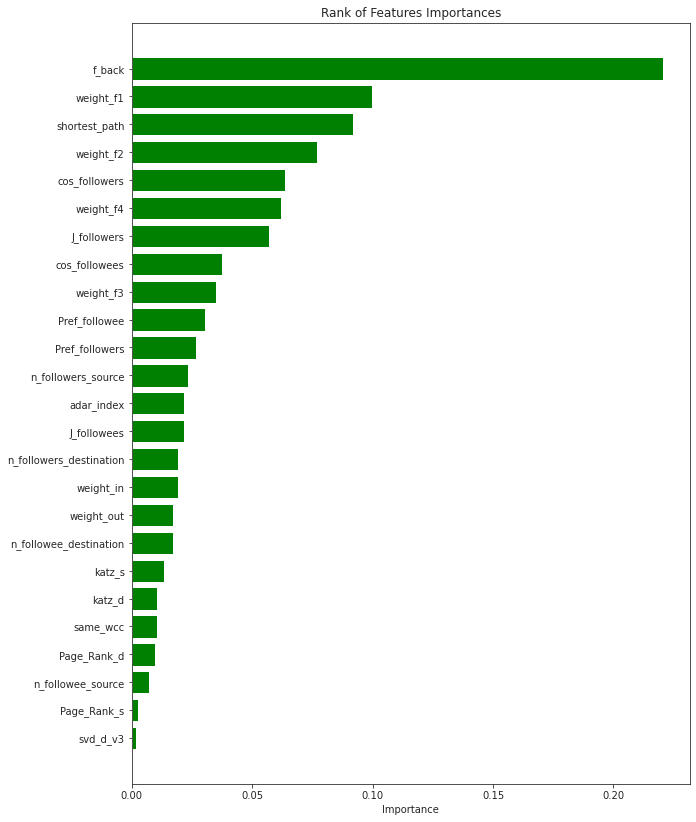

In [ ]:
# Features Importances of RandomForestClassifier
X=df_train.columns
important=rfc.feature_importances_
index=(np.argsort(important))[-25:]
plt.figure(figsize=(10,14))
plt.title('Rank of Features Importances')
plt.barh(range(len(index)), important[index], color='g',align='center')
plt.yticks(range(len(index)),[X[i] for i in index])
plt.xlabel('Importance')
plt.show()

********************************


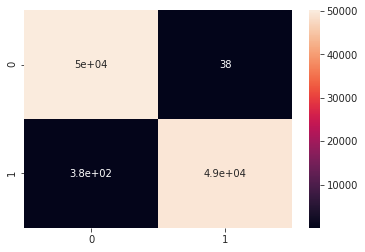

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_train=confusion_matrix(y_train_f,predicted)
confusion_test=confusion_matrix(y_test_f,predicted_t)


sns.heatmap(confusion_train, annot=True)




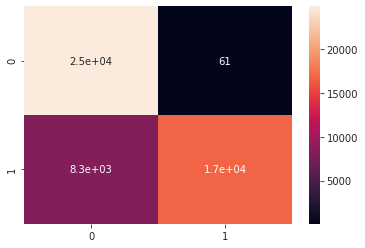

In [ ]:
sns.heatmap(confusion_test ,annot=True)

In [ ]:
df_train.columns

Index(['J_followees', 'J_followers', 'cos_followees', 'cos_followers',
       'Page_Rank_s', 'Page_Rank_d', 'shortest_path', 'same_wcc', 'adar_index',
       'f_back', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'n_followers_source', 'n_followee_source',
       'n_followers_destination', 'n_followee_destination', 'Pref_followers',
       'Pref_followee', 'svd_s_u1', 'svd_s_u2', 'svd_s_u3', 'svd_s_u4',
       'svd_s_u5', 'svd_s_u6', 'svd_d_u1', 'svd_d_u2', 'svd_d_u3', 'svd_d_u4',
       'svd_d_u5', 'svd_d_u6', 'svd_s_v1', 'svd_s_v2', 'svd_s_v3', 'svd_s_v4',
       'svd_s_v5', 'svd_s_v6', 'svd_d_v1', 'svd_d_v2', 'svd_d_v3', 'svd_d_v4',
       'svd_d_v5', 'svd_d_v6', 'SVD_DOT'],
      dtype='object')

In [ ]:
from xgboost import XGBClassifier

model=XGBClassifier( max_depth=5,
                    subsample=0.5,
                    n_estimators=200,
                    learning_rate=0.01,
                    min_child_weight=1
                    )

model.fit(df_train,y_train_f)
predicted=model.predict(df_train)
F1_score=f1_score(y_train_f,predicted)
print(F1_score)
print('**********************************')
predicted_t=model.predict(df_test)
F1_score_t=f1_score(y_test_f,predicted_t)
print(F1_score_t)

0.9521767368019545
**********************************
0.8011361033487563


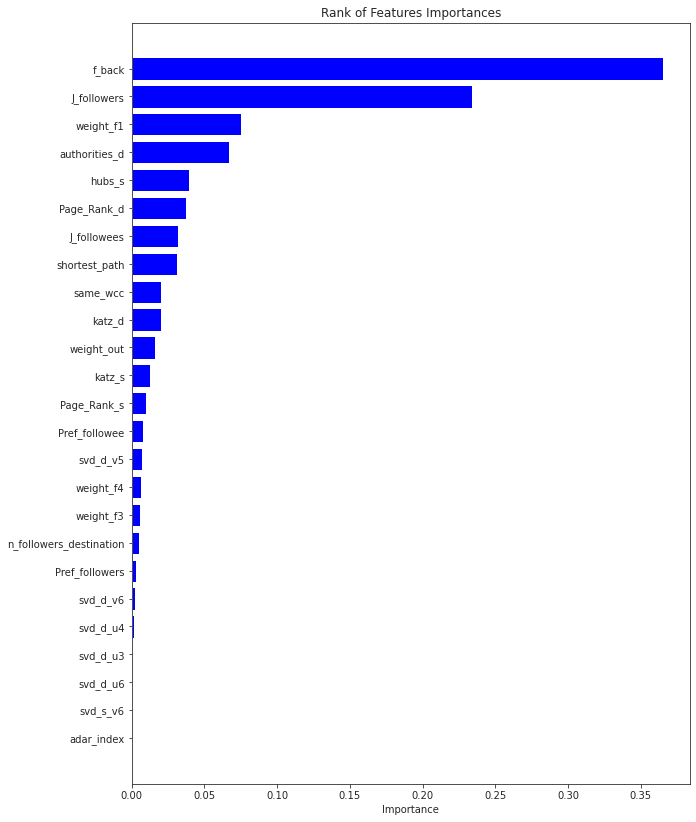

In [ ]:
# Features importance for xg boost
X=df_train.columns
important=model.feature_importances_
index=(np.argsort(important))[-25:]
plt.figure(figsize=(10,14))
plt.title('Rank of Features Importances')
plt.barh(range(len(index)), important[index], color='b',align='center')
plt.yticks(range(len(index)),[X[i] for i in index])
plt.xlabel('Importance')
plt.show()